<a href="https://colab.research.google.com/github/Ashusaggu/INFO-5731-SPRING-2024/blob/main/Saggu_Aasreetha_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the cl. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def read_file(path):
    text, sentiments = [], []
    file = open(path).read()
    for i, j in enumerate(file.split("\n")):
        new_file = j.split(' ')
        text.append(" ".join(new_file[1:]))
        sentiments.append(new_file[0])
    return text, sentiments

In [3]:
def preprocess(df):
    # converting the sentiment classes to integers.
    df['Sentiment'] = pd.to_numeric(df['Sentiment'], errors='coerce')

    # Dropping the row with NaN in the output variable
    df = df.dropna(subset=['Sentiment'])

    # removing the special chacters
    df['remove_noise'] = df['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', ch) for ch in x))

    # removing the punctuation marks
    df['remove_punc'] = df['remove_noise'].str.replace('[^\w\s]', '')

    # removing the stop words
    stop_word = stopwords.words('english')
    df['remove_sw'] = df['remove_punc'].apply(
        lambda x: " ".join(w for w in x.split() if w not in stop_word))

    # lowercasing the letters from upper case
    df['lower'] = df['remove_sw'].apply(lambda x: " ".join(w.lower() for w in x.split()))

    return df


In [4]:
def vectorize(train, test):
    # Applying tf idf vector
    tfidf = TfidfVectorizer(analyzer='word')
    tfidf.fit(train['lower'])
    x_train = tfidf.transform(train['lower'])
    tfidf_test_vec = TfidfVectorizer(analyzer='word', vocabulary=tfidf.vocabulary_)
    tfidf_test_vec.fit(test['lower'])
    x_test = tfidf_test_vec.transform(test['lower'])

    return x_train, x_test

In [5]:
def evaluate(cl, x_train, y_train, x_test, y_test): #method for evaluating the models
    cl.fit(x_train, y_train)
    pred = cl.predict(x_test)
    acc = accuracy_score(pred, y_test)
    print(f"Accuracy of the model {cl.__class__.__name__}: {acc}")

    if 'XGB' not in str(cl):
        scoring = 'accuracy'
        kf = KFold(10, random_state=7, shuffle=True)
        cv_score = cross_val_score(cl, x_test, y_test, cv=kf, scoring=scoring).mean()
        print(f"Cross-validation score of model {cl.__class__.__name__}: {cv_score}")

    print(f"\nClassification Report of model {cl.__class__.__name__} is:\n")
    print(classification_report(y_test, pred))
    print("\n---------------------------------------------------------------\n")


In [6]:

train_data, train_senti = read_file('stsa-train.txt')
test_data, test_senti = read_file('stsa-test.txt')

# Creating data frames for training and testing
train_df = pd.DataFrame(list(zip(train_senti, train_data)), columns=['Sentiment', 'Raw Data'])
test_df = pd.DataFrame(list(zip(test_senti, test_data)), columns=['Sentiment', 'Raw Data'])

# Pre-processing the  data using the method preprocess
train_df = preprocess(train_df)
test_df = preprocess(test_df)

# Vectorizing the data using vectorize method
x_train, x_test = vectorize(train_df, test_df)

# Splitting the data for training and testing the model
x_train, x_tst, y_train, y_tst = model_selection.train_test_split(x_train, train_df['Sentiment'],
                                                                      test_size=0.2, random_state=42)


In [7]:

y_train = y_train.astype(int)#making the target variables numerical
y_tst = y_tst.astype(int)

# making a list of classifiers
cls = [
    naive_bayes.MultinomialNB(),
    svm.SVC(),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Evaluating each classifier on the testing set of data
for cl in cls:
    print(f"Evaluating the model {cl.__class__.__name__} on the test set:")
    evaluate(cl, x_train, y_train, x_test, test_df['Sentiment'])


Evaluating the model MultinomialNB on the test set:
Accuracy of the model MultinomialNB: 0.7924217462932455
Cross-validation score of model MultinomialNB: 0.7254368582237435

Classification Report of model MultinomialNB is:

              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77       912
         1.0       0.74      0.90      0.81       909

    accuracy                           0.79      1821
   macro avg       0.81      0.79      0.79      1821
weighted avg       0.81      0.79      0.79      1821


---------------------------------------------------------------

Evaluating the model SVC on the test set:
Accuracy of the model SVC: 0.7990115321252059
Cross-validation score of model SVC: 0.7089683540503213

Classification Report of model SVC is:

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79       912
         1.0       0.77      0.85      0.81       909

    accuracy                     

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Splitting the data into training and testing sets
tr_df = preprocess(train_df)
ts_df = preprocess(test_df)

tr_df, ts_df = train_test_split(tr_df, test_size=0.2, random_state=42)

# Tokenizing the  raw data
tr_token = tr_df['Raw Data'].apply(word_tokenize)
ts_token = ts_df['Raw Data'].apply(word_tokenize)

# Training the  Word2Vector model
w2v = Word2Vec(sentences=tr_token, vector_size=100, window=5, min_count=1, workers=4)

# creating documents vectors
def get_vec(model, tok):
    vector = [model.wv[w] for w in tok if w in model.wv.index_to_key]
    return sum(vector) / len(vector) if vector else [0] * model.vector_size

# Creating document vectors for training and testing data
X_tr = tr_token.apply(lambda x: get_vec(w2v, x)).to_list()
X_ts = ts_token.apply(lambda x: get_vec(w2v, x)).to_list()

# Converting the list of vectors
X_tr = pd.DataFrame(X_tr)
X_ts = pd.DataFrame(X_ts)

# Convert 'Sentiment' to numeric values if it's not already done
tr_df['Sentiment'] = tr_df['Sentiment'].astype(int)
ts_df['Sentiment'] = ts_df['Sentiment'].astype(int)

lr_cl = LogisticRegression()#logistic regression model
lr_cl.fit(X_tr, tr_df['Sentiment'])
lr_pred = lr_cl.predict(X_ts)

# Evaluating the performance of the model
lr_accuracy = accuracy_score(ts_df['Sentiment'], lr_pred)
lr_precision = precision_score(ts_df['Sentiment'], lr_pred)
lr_recall = recall_score(ts_df['Sentiment'], lr_pred)
lr_f1 = f1_score(ts_df['Sentiment'], lr_pred)
#cross validation
cv_scores_lr = cross_val_score(lr_cl, pd.concat([X_tr, X_ts]), pd.concat([tr_df['Sentiment'], ts_df['Sentiment']]), cv=10, scoring='accuracy')

#results
cv_lr = pd.DataFrame({
    'Model': ['Word2Vec'],
    'Accuracy': [cv_scores_lr.mean()],
    'Precision': [cross_val_score(lr_cl, pd.concat([X_tr, X_ts]), pd.concat([tr_df['Sentiment'], ts_df['Sentiment']]), cv=10, scoring='precision').mean()],
    'Recall': [cross_val_score(lr_cl, pd.concat([X_tr, X_ts]), pd.concat([tr_df['Sentiment'], ts_df['Sentiment']]), cv=10, scoring='recall').mean()],
    'F1 Score': [cross_val_score(lr_cl, pd.concat([X_tr, X_ts]), pd.concat([tr_df['Sentiment'], ts_df['Sentiment']]), cv=10, scoring='f1').mean()]
})

print(cv_lr)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


      Model  Accuracy  Precision    Recall  F1 Score
0  Word2Vec  0.575723   0.568974  0.769529  0.654156


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming 'Sentiment' is initially stored as strings
tr_df['Sentiment'] = tr_df['Sentiment'].astype(int)

# Split the data into features and Sentiments
X_raw = tr_df['Raw Data']
y_Sentiments = tr_df['Sentiment']

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Assuming binary classification, adjust num_Sentiments accordingly

# Initialize 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize metrics storage
cv_metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

# Iterate through folds
for train_index, test_index in cv.split(X_raw, y_Sentiments):
    X_train, X_test = X_raw.iloc[train_index], X_raw.iloc[test_index]
    y_train, y_test = y_Sentiments.iloc[train_index], y_Sentiments.iloc[test_index]

    # Tokenize the Raw Data data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='pt')

    # Convert Sentiments to PyTorch tensors
    y_train_tensor = torch.tensor(y_train.values.astype(int))
    y_test_tensor = torch.tensor(y_test.values.astype(int))

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Set device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=5e-5)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_predictions = []
    all_Sentiments = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), Sentiments.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_Sentiments.extend(Sentiments.cpu().numpy())

    # Convert predictions and Sentiments to NumPy arrays
    predictions_array = np.array(all_predictions)
    Sentiments_array = np.array(all_Sentiments)

    # Calculate metrics
    accuracy = accuracy_score(Sentiments_array, predictions_array)
    precision = precision_score(Sentiments_array, predictions_array)
    recall = recall_score(Sentiments_array, predictions_array)
    f1 = f1_score(Sentiments_array, predictions_array)

    # Append metrics to the storage
    cv_metrics['Model'].append('BERT')
    cv_metrics['Accuracy'].append(accuracy)
    cv_metrics['Precision'].append(precision)
    cv_metrics['Recall'].append(recall)
    cv_metrics['F1 Score'].append(f1)

# Create a DataFrame to store the cross-validation results for BERT
cv_metrics_df_bert = pd.DataFrame(cv_metrics)

# Append the metrics for BERT to the existing metrics_df
#metrics_df = metrics_df.append(cv_metrics_df_bert.mean(), ignore_index=True)

# Print the combined metrics DataFrame
print(cv_metrics_df_bert )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [13]:
import pandas as pd

amazon = pd.read_csv('amazon_mobile_new.csv')
amazon.dropna(subset=['Reviews'], inplace=True)
amazon

Product Name Brand Name   Price  \
0     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
...                                                 ...        ...     ...   
9994               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9995               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9996               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9997               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9998               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   

      Rating                                            Reviews  Review Votes  
0          5  I feel so LUCKY to have found this used (phone...           1.0  
1          4  nice phone, nice up grade from my pantach revu...           0.0  
2          5                                       Very pleased           0.0  
3          4  It works good but it goes slow sometimes but i...           0.0  
4          4  Great phone to replace my lost phone. The only...           0.0  
...      ...                                                ...           ...  
9994       5  I bought this phone for a teenage boy who can ...           2.0  
9995       1  Words can't describe how unsatisfied I am. The...           2.0  
9996       2  First of all the Iphone receive was in great c...           2.0  
9997       4  Should of been black color but only had white ...           0.0  
9998       1  The phone was NOT unlocked when I received it....           0.0  

[9998 rows x 6 columns]

In [14]:
def rating(x):
    if x == 5:
        return 'Great'
    elif x == 4:
        return 'Good'
    elif x == 3:
        return 'Average'
    elif x == 2:
        return 'Not Good'
    return 'Bad'

#creating labels for the ratings from 1-5
score = amazon['Rating']
rating_label = score.map(rating)
amazon['Rating'] = rating_label

amazon

Product Name Brand Name   Price  \
0     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4     "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
...                                                 ...        ...     ...   
9994               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9995               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9996               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9997               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   
9998               Apple iPhone 4 8GB, Unlocked (Black)        NaN  122.00   

        Rating                                            Reviews  \
0        Great  I feel so LUCKY to have found this used (phone...   
1         Good  nice phone, nice up grade from my pantach revu...   
2        Great                                       Very pleased   
3         Good  It works good but it goes slow sometimes but i...   
4         Good  Great phone to replace my lost phone. The only...   
...        ...                                                ...   
9994     Great  I bought this phone for a teenage boy who can ...   
9995       Bad  Words can't describe how unsatisfied I am. The...   
9996  Not Good  First of all the Iphone receive was in great c...   
9997      Good  Should of been black color but only had white ...   
9998       Bad  The phone was NOT unlocked when I received it....   

      Review Votes  
0              1.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
9994           2.0  
9995           2.0  
9996           2.0  
9997           0.0  
9998           0.0  

[9998 rows x 6 columns]

In [15]:
amazon['Rating'].value_counts()

Rating
Great       4994
Bad         2117
Good        1379
Average      831
Not Good     677
Name: count, dtype: int64

In [16]:
subset = ["Product Name", "Brand Name", "Price", "Rating", "Reviews", "Review Votes"]
final_data = amazon.drop_duplicates(subset=subset, keep='first', inplace=False)
final_data.shape

(8479, 6)

In [17]:
pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.8 MB/s eta 0:00:00


In [18]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
snowball = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer which is developed in recent years
stop_words = set(stopwords.words('english'))
import demoji
import string
#cleaning the data
def clean_text(data):
    #splitting the data into words
    words = data.split()

    #removing words that start with @
    cleaned = [w for w in words if not w.startswith('@')]

    # removing the links
    cleaned = [w for w in cleaned if not w.startswith('http')]

    # converting the letters to lower case
    low = ' '.join(cleaned).lower()

    # Removing any emjis if present
    txt = demoji.replace(low, '')

    # Removing punctuation marks
    txt = txt.translate(str.maketrans('', '', string.punctuation))

    # Removing numerical values
    txt = ''.join(i for i in txt if not i.isdigit())

    # Removing stopwords
    txt = ' '.join(i for i in txt.split() if i not in stop_words)

    return txt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
clean_review = []

for idx, row in final_data.iterrows():
    review = clean_text(row['Reviews'])
    clean_review.append(review)

final_data['Cleaned Reviews'] = clean_review

In [20]:
 #Generating bag of words
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer()
bag_of_words = c_vec.fit_transform(final_data['Cleaned Reviews'].values)
bag_of_words.shape


(8479, 12580)

In [23]:

trm = c_vec.get_feature_names_out()
trm[1:10]

array(['aaa', 'aand', 'aarp', 'abble', 'abcell', 'abetter', 'abide',
       'ability', 'abiut'], dtype=object)

In [24]:
#K-MEANS MODEL

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(bag_of_words)

KMeans(n_clusters=10, random_state=42)

In [25]:
lbl = kmeans.labels_
center=kmeans.cluster_centers_
center

array([[0.        , 0.        , 0.00496278, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00537634, 0.        ,
        0.        ],
       [0.15384615, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00031358, 0.        , 0.        , ..., 0.00031358, 0.00031358,
        0.00031358],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
#Labelling of the clusters
amazon = final_data
amazon['Bag_of_words Label'] = kmeans.labels_
amazon.head(10)

Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
5  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
6  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
7  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
8  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
9  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

     Rating                                            Reviews  Review Votes  \
0     Great  I feel so LUCKY to have found this used (phone...           1.0   
1      Good  nice phone, nice up grade from my pantach revu...           0.0   
2     Great                                       Very pleased           0.0   
3      Good  It works good but it goes slow sometimes but i...           0.0   
4      Good  Great phone to replace my lost phone. The only...           0.0   
5       Bad  I already had a phone with problems... I know ...           1.0   
6  Not Good  The charging port was loose. I got that solder...           0.0   
7  Not Good  Phone looks good but wouldn't stay charged, ha...           0.0   
8     Great  I originally was using the Samsung S2 Galaxy f...           0.0   
9   Average  It's battery life is great. It's very responsi...           0.0   

                                     Cleaned Reviews  Bag_of_words Label  
0  feel lucky found used phone us used hard phone...                   8  
1  nice phone nice grade pantach revue clean set ...                   8  
2                                            pleased                   3  
3     works good goes slow sometimes good phone love                   8  
4  great phone replace lost phone thing volume bu...                   8  
5  already phone problems know stated used dang s...                   8  
6  charging port loose got soldered needed new ba...                   8  
7  phone looks good wouldnt stay charged buy new ...                   8  
8  originally using samsung galaxy sprint wanted ...                   9  
9  battery life great responsive touch issue some...                   3

In [27]:
amazon.groupby(['Bag_of_words Label'])['Reviews'].count()

Bag_of_words Label
0     403
1     186
2      13
3    3989
4       1
5      15
6       1
7       1
8    3189
9     681
Name: Reviews, dtype: int64

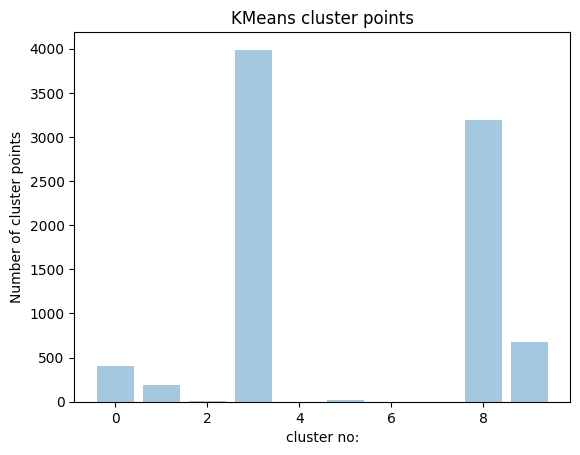

In [28]:
#creating visualizations for the clusters
import matplotlib.pyplot as plt
plt.bar([x for x in range(10)], amazon.groupby(['Bag_of_words Label'])['Reviews'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("cluster no:")
plt.ylabel("Number of cluster points")
plt.show()

In [29]:
for i in range(10):
    print("Cluster assigned to review", i)
    print("-" * 70)
    print(amazon.iloc[amazon.groupby(['Bag_of_words Label']).groups[i][0]]['Reviews'])
    print('\n')
    print("_" * 70)

Cluster assigned to review 0
----------------------------------------------------------------------
Bought it as a gift for my Mum and she loves it. It is a strong durable phone, has good reception and it functions well.


______________________________________________________________________
Cluster assigned to review 1
----------------------------------------------------------------------
I purchased this phone in December as a christmas present to my son. I called sprint to activate the phone only to find out the ESN wasn't clear. I was told to come into the store and upon research the phone wasn't clear. I reached out to this company to inform them that this ESN wasn't clean. I was told to send the phone back and they would send out another phone. I asked the representative to provide me with the ESN # so that I could call and make sure it was clear. I was told that they didn't have to phone available and was guaranteed it would be clear. I should've known something was wrong then.

In [30]:
#Creating the original text corpus
sentences=[]
for s in final_data['Cleaned Reviews'].values:
    sentences.append(s.split())

print(final_data['Cleaned Reviews'].values[0])
print("-------------------------------------------------")
print(sentences[0])

feel lucky found used phone us used hard phone line someone upgraded sold one son liked old one finally fell apart years didnt want upgrade thank seller really appreciate honesty said used phonei recommend seller highly would
-------------------------------------------------
['feel', 'lucky', 'found', 'used', 'phone', 'us', 'used', 'hard', 'phone', 'line', 'someone', 'upgraded', 'sold', 'one', 'son', 'liked', 'old', 'one', 'finally', 'fell', 'apart', 'years', 'didnt', 'want', 'upgrade', 'thank', 'seller', 'really', 'appreciate', 'honesty', 'said', 'used', 'phonei', 'recommend', 'seller', 'highly', 'would']


In [31]:
import re
def clean_html(sent):
    clean_ = re.compile('<.*?>')
    clean_txt = re.sub(clean_, ' ', sent)
    return clean_txt
def clean_punctuation(sent):
    clean_punct= re.sub(r'[?|!|\'|"|#]',r'',sent)
    clean_punct = re.sub(r'[.|,|)|(|\|/]',r' ',clean_punct)
    return  clean_punct

sent_train=[]
for sen in final_data['Reviews'].values:
    filtered=[]
    sent=clean_html(sen)
    for w in sen.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered.append(cleaned_words.lower())
            else:
                continue
    sent_train.append(filtered)

In [32]:
import gensim
import numpy as np

# Training the word2vec model using the original text corpus
w2v = gensim.models.Word2Vec(sent_train, vector_size=100, workers=4)

sent_vect = []

for sent in sent_train:
    s_vec = np.zeros(100)
    cnt_words = 0

    for word in sent:
        try:
            vec = w2v.wv[word]
            s_vec += vec
            cnt_words += 1
        except KeyError:
            pass

    s_vec = s_vec/cnt_words
    sent_vect.append(s_vec)

sent_vect = np.array(sent_vect)
sent_vect = np.nan_to_num(sent_vect)
sent_vect.shape

(8479, 100)

In [33]:
from sklearn.cluster import DBSCAN

#As a sample, computing 200th nearest neighbour distance
minPts = 2 * 100

#Calculating the lower bound
def lb(nos, tg):
    l, r = 0, len(nos) - 1
    while l <= r:
        mid = int(l + (r - l) / 2)
        if nos[mid] >= tg:
            r = mid - 1
        else:
            l = mid + 1
    return l

def distance(x, dt):
    dist = []
    for v in dt:
        #Computing distances
        d = np.sum((x - v) **2 )

        if(len(dist) == 200 and dist[199] > d):

            #Using the lower_bound func to get the right position
            l = int(lb(dist, d))
            if l < 200 and l >= 0 and dist[l] > d:
                dist[l] = d
        else:
            dist.append(d)
            dist.sort()

    return dist[199]

In [34]:
#Calculating the distance
dis_lis= []
for v in sent_vect[:1500]:
    dis_lis.append(distance(v, sent_vect[:1500]) )
dis_lis.sort()

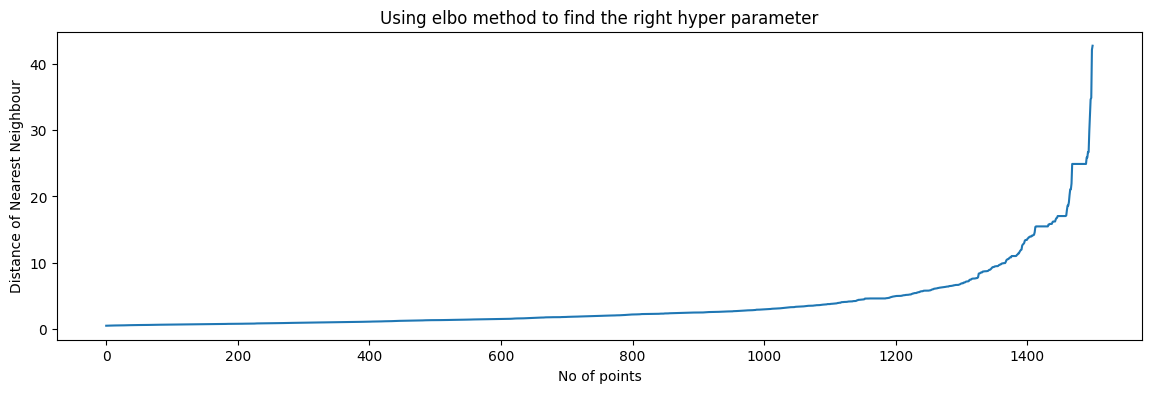

In [35]:
#For the Elbow Method
plt.figure(figsize=(14,4))
plt.title("Using elbo method to find the right hyper parameter")
plt.plot([i for i in range(len(dis_lis))], dis_lis)
plt.xlabel("No of points")
plt.ylabel("Distance of Nearest Neighbour")
plt.show()

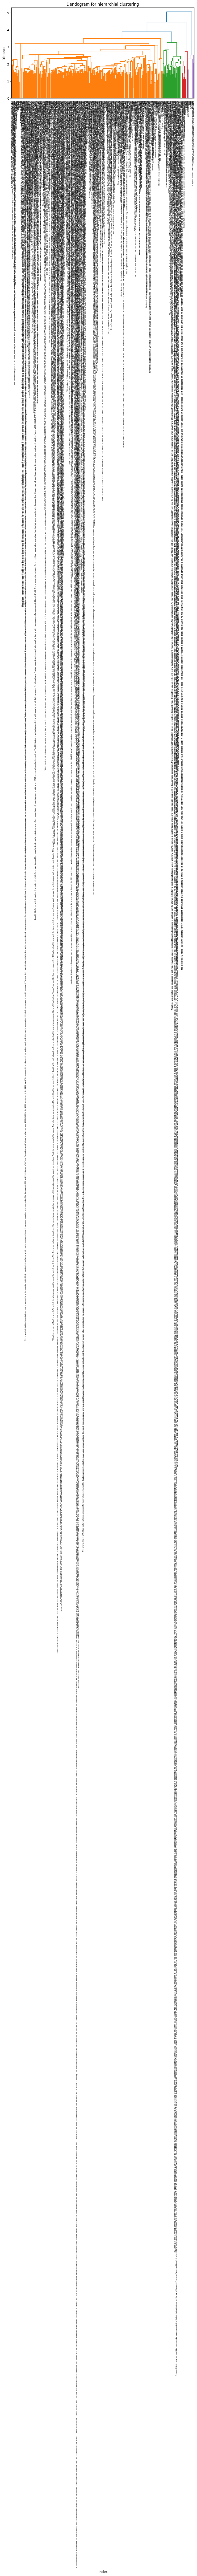

Cluster 1: ["I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!", 'The charging port was loose. I got that soldered in. Then needed a new battery as well. $100 later (not including cost of purchase) I have a usable phone. The phone should not have been sold in the state it was in.']
Cluster 2: ['nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung', 'Very pleased', 'It works good but it goes slow sometimes but its a very good phone I love it', 'Great phone to replace my lost phone. The only thing is the volum

In [38]:
#Hierarchical clustering Model
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

#taking only 500 reviews for this problem since colab is crashing
review = amazon['Reviews'][:500].tolist()

#tf-idf vector transformation
vector = TfidfVectorizer(stop_words='english')
X_vec = vector.fit_transform(review)

#Calculating the cosine similarity
cos_similar = cosine_similarity(X_vec)

#Apply hierarchical clustering
link_matr = linkage(1 - cos_similar, method='complete')

#visualizong using a dendrogram
plt.figure(figsize=(10, 5))
dendrogram(link_matr, labels=review, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendogram for hierarchial clustering')
plt.xlabel(' Index')
plt.ylabel('Distance')
plt.show()

no_clusters = 3
label = AgglomerativeClustering(n_clusters=no_clusters, affinity='cosine', linkage='complete').fit_predict(1 - cos_similar)

for cl_id in range(no_clusters):
    cl_indcs = np.where(labels == cl_id)[0]
    cl_review = [review[i] for i in cl_indcs]
    print(f"Cluster {cl_id + 1}: {cl_review}")

In [48]:
#Word2Vec Model
import re
import gensim
import numpy as np
from sklearn.cluster import KMeans

#Preprocessing of thr text data for creating the original text
def remove_html(stc):
    clean_b = re.compile('<.*?>')
    clean_bt = re.sub(clean_b, ' ', stc)
    return clean_bt
def remove_punctuation(stc):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',stc)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
sent_train=[]
for s in final_data['Reviews'].values:
    filter_s=[]
    s=remove_html(s)
    for w in s.split():
        for clean_wrd in remove_punctuation(w).split():
            if(clean_wrd.isalpha()):
                filter_s.append(clean_wrd.lower())
            else:
                continue
    sent_train.append(filter_s)

#Taking only 500 reviews because system is crashing
rvw = amazon['Reviews'][:500].tolist()

#word2vec model building
w2v = gensim.models.Word2Vec(sent_train, vector_size=100, workers=4)
#preprocessing steps
def preprocess(dta):
    #Lowercasing the letters
    dta = dta.lower()

    #Removal of stopwords
    stop = set(stopwords.words('english'))
    txt_wrds = [w for w in dta.split() if w not in stop]

    #Converting data to word embeddings
    word_embeds= []
    for w in txt_wrds:
        try:
            word_embed = w2v.wv[w]
        except KeyError:
            word_embed = np.zeros(w2v.vector_size)
        word_embeds.append(word_embed)

    #Calculating the average
    doc_embed = np.mean(word_embeds, axis=0)

    return doc_embed

# preprocess functions and collect embedded texts
doc_embeds = []
for rev in rvw:
    doc_embed = preprocess(rev)
    doc_embeds.append(doc_embed)

#K-means clustering model
kmeans = KMeans(n_clusters=2)
cl_label = kmeans.fit_predict(doc_embeds)

In [55]:
#Creating a dataframe for Word2Vec results
w_df = pd.DataFrame({
    'W2v_X': [em[0] for em in doc_embeds],
    'W2v_Y': [em[1] for em in doc_embeds],
    'Clusters': cl_label
})

#Creating a visualization
if w2v.vector_size == 2:
    plt.figure(figsize=(10, 6))
    for cl_id in range(kmeans.n_clusters):
        cl_pts = w_df[w2v_df['Cluster'] == cl_id]
        plt.scatter(cl_pts['W2v_X'], cl_pts['W2v_Y'], label=f'Clusters {cl_id}')

    plt.title('K-means Clustering with Word2Vector Embeddings')
    plt.xlabel('Word2Vector Dimension 1')
    plt.ylabel('Word2Vector Dimension 2')
    plt.legend()
    plt.show()
else:
    print("2D VISUALIZATION IS SKIPPED")
print("Cluster Centroids:")
print(kmeans.cluster_centers_)

2D VISUALIZATION IS SKIPPED
Cluster Centroids:
[[-0.02955811  0.10458516 -0.02697859  0.09589014  0.14977932 -0.14404707
   0.02805379  0.42185665 -0.07709891 -0.06633258 -0.10534509 -0.16641194
  -0.05078832  0.08877334  0.08663402 -0.12294374  0.01134296 -0.03028043
  -0.02931506 -0.4176081   0.09029443 -0.010841    0.1151201   0.00510714
  -0.02132906 -0.03985935 -0.12233342 -0.00716674 -0.18747647  0.10690402
   0.02708152 -0.08058433 -0.08257883 -0.26998697 -0.04032182  0.08536008
   0.04926695 -0.17077083 -0.02175326 -0.23242249  0.01417034 -0.0634319
  -0.08072604  0.0172315   0.19869278 -0.03069343 -0.08795576 -0.01049612
   0.1425152   0.15697483  0.14092474 -0.21779874 -0.02856667 -0.15715087
  -0.05444992 -0.04028295  0.08347934 -0.1061731  -0.02135456 -0.07286652
   0.04314963 -0.04743046  0.08986963  0.02464288 -0.21058802  0.19780816
   0.07081523  0.25277093 -0.42677603  0.25781781 -0.02702377  0.13697965
   0.12134824 -0.00904528  0.19770886  0.01696215  0.06137239  0.0

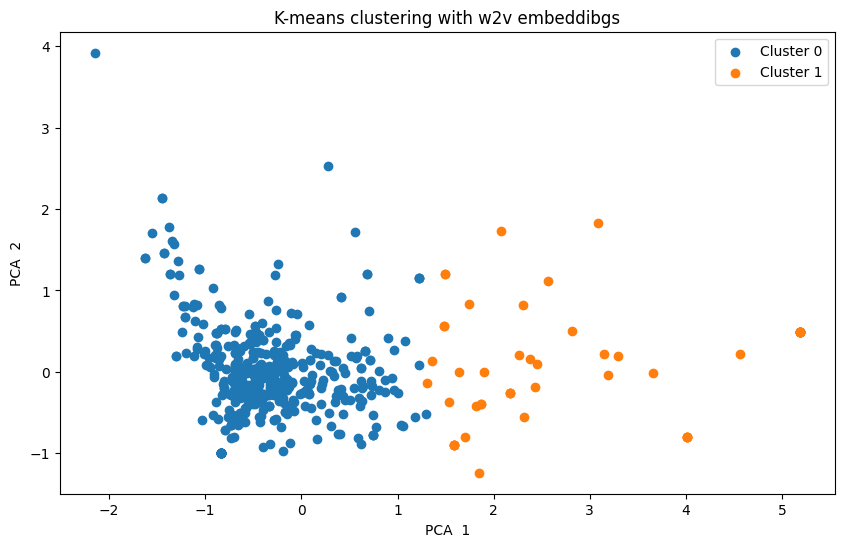

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
w_pca = pca.fit_transform(doc_embeds)
w_df['PCA_1'] = w_pca[:, 0]
w_df['PCA_2'] = w_pca[:, 1]
plt.figure(figsize=(10, 6))
for cl_id in range(kmeans.n_clusters):
    cl_pts = w_df[w_df['Clusters'] == cl_id]
    plt.scatter(cl_pts['PCA_1'], cl_pts['PCA_2'], label=f'Cluster {cl_id}')

plt.title('K-means clustering with w2v embeddibgs')
plt.xlabel('PCA  1')
plt.ylabel('PCA  2')
plt.legend()
plt.show()

In [58]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

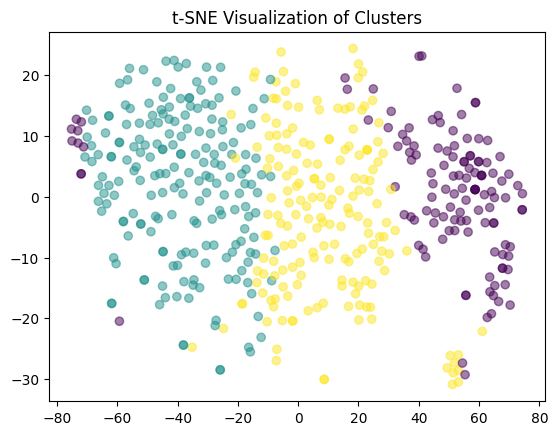

In [59]:
#BERT Model
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Intitalizing bert model
bert = SentenceTransformer('bert-base-nli-mean-tokens')

#Because the original column is too big and the system can crash
rvw= amazon['Reviews'][:500].tolist()

#Embedding texts for machine readable formats
embed_review = bert.encode(rvw)

#K-means clustering
kmeans = KMeans(n_clusters=3)
cl_lbls = kmeans.fit_predict(embed_review)

#For a visualization
tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(embed_review)

#Creating a scatter plot
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=cl_lbls, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Clusters')
plt.show()

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.In k means clustering the datapoints are grouped according to their similarity by the algorithm. The datapoints that are not similar are removed and grouped with the nearest centroid point. In Dbscan algorithm datapoints are grouped based on degree of similarity. all the data with high densities are grouped together and and lower density are grouped together.
In hieriachical clustering the data points are grouped hierarchically like the structure of the tree.Word2vector model performs well with small datasets. It will determine which word will occur next in the text.
Bert is a very efficient model while dealing with large datasets. Out of all the models bert has performed efficiently.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [60]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
The excercise was tough and time taking. since the dataset is large, colab was crashing over and over again.




'''

'\nPlease write you answer here:\nThe excercise was tough and time taking. since the dataset is large, colab was crashing over and over again.\n\n\n\n\n'